In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from meteostat import Point, Daily
from datetime import datetime, timedelta
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import warnings
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL
from sklearn.model_selection import GridSearchCV
import pmdarima as pm
from prophet import Prophet

Importing plotly failed. Interactive plots will not work.


# Explorative Daten Analyse

In [2]:
# Zeitraum für Vergangenheitsdaten (letzte 50 Jahre, falls verfügbar)
start_date = datetime(1980, 1, 1)  # Statt 1940, um Lücken zu vermeiden
end_date = datetime(2024, 3, 1)

# Punkt für Bakersfield, USA
location = Point(35.3733, -119.0187)

# Daten von Meteostat API abrufen
data = Daily(location, start_date, end_date).fetch()

## Summary Statistics:

In [3]:
print(data.describe())

               tavg          tmin          tmax          prcp          snow  \
count  15808.000000  16132.000000  16132.000000  16132.000000  16130.000000   
mean      18.692371     11.926141     25.665485      0.435148      0.004712   
std        7.924751      6.987263      8.914693      2.099032      0.598407   
min      -17.800000     -7.200000      1.100000      0.000000      0.000000   
25%       12.200000      6.100000     18.300000      0.000000      0.000000   
50%       18.000000     11.100000     25.600000      0.000000      0.000000   
75%       25.600000     17.800000     33.300000      0.000000      0.000000   
max       37.200000     30.000000     46.100000     38.900000     76.000000   

              wdir          wspd         wpgt          pres    tsun  
count  6303.000000  16114.000000  5765.000000  15691.000000  1137.0  
mean    236.081548      9.953736    27.918508   1015.376566     0.0  
std     130.241231      3.673261     9.454404      5.222055     0.0  
min     

## Missing values:

In [4]:
print(data.isnull().sum())

tavg      324
tmin        0
tmax        0
prcp        0
snow        2
wdir     9829
wspd       18
wpgt    10367
pres      441
tsun    14995
dtype: int64


## Histogram for each column

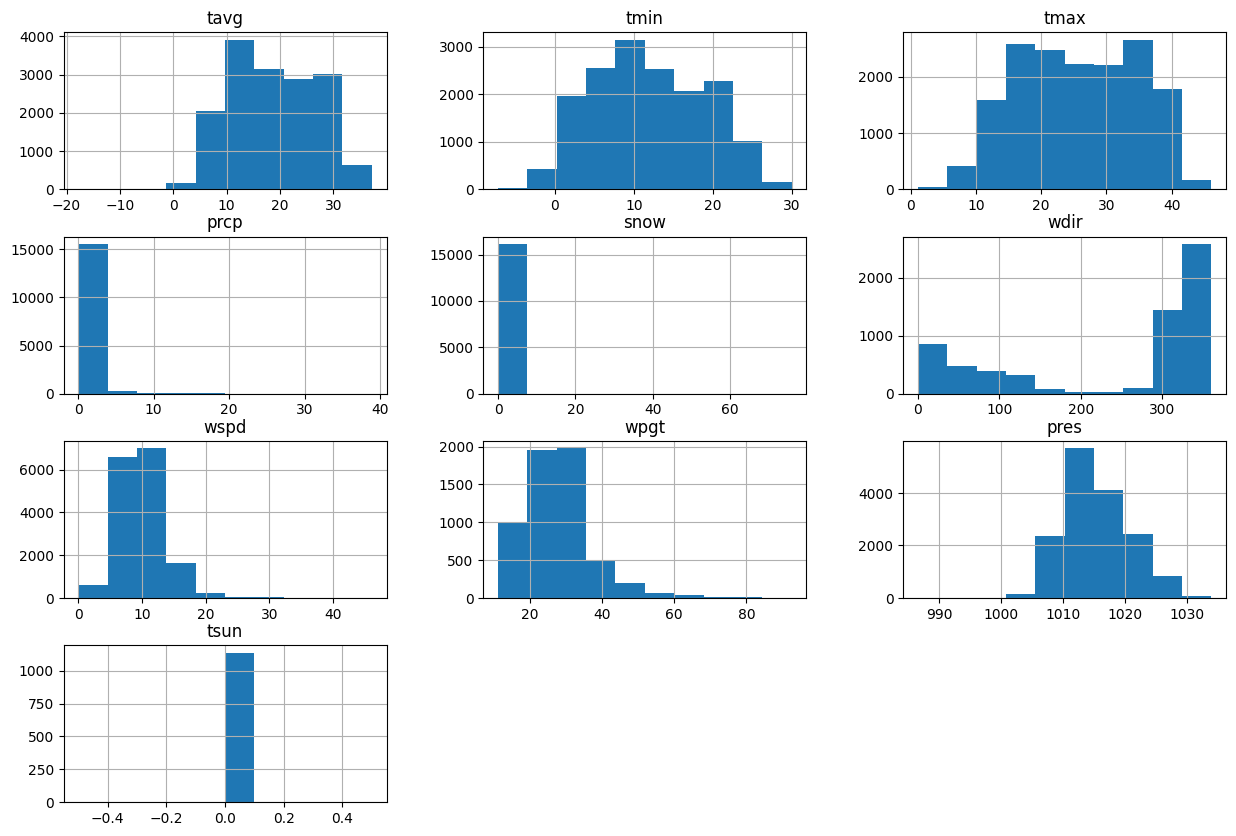

In [5]:
data.hist(figsize=(15, 10))
plt.show()

## Correlation Matrix:

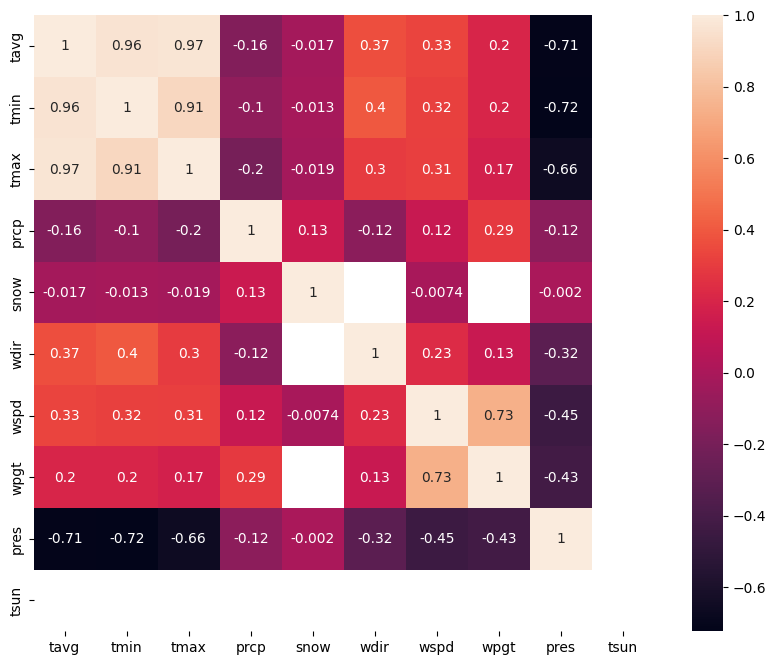

In [6]:
plt.figure(figsize=(10, 8))
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=True)
plt.show()

# Boxplot

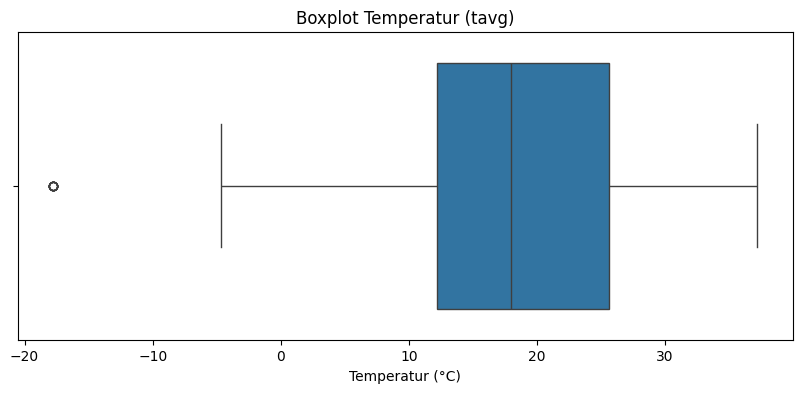

In [7]:
plt.figure(figsize=(10, 4))
sns.boxplot(x=data['tavg'])
plt.title('Boxplot Temperatur (tavg)')
plt.xlabel('Temperatur (°C)')
plt.show()

Q1 = data['tavg'].quantile(0.25)
Q3 = data['tavg'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
data['tavg'] = data['tavg'].clip(lower=lower_bound, upper=upper_bound)

## Time series for average temperature:

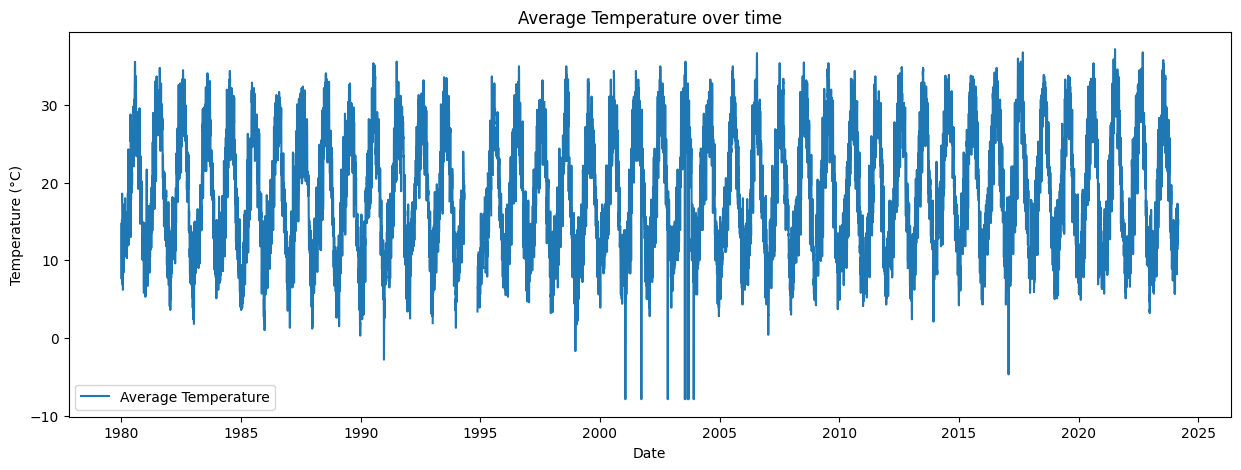

In [8]:
plt.figure(figsize=(15, 5))
plt.plot(data.index, data['tavg'], label='Average Temperature')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.title('Average Temperature over time')
plt.legend()
plt.show()

18:01:20 - cmdstanpy - INFO - Chain [1] start processing
18:01:21 - cmdstanpy - INFO - Chain [1] done processing


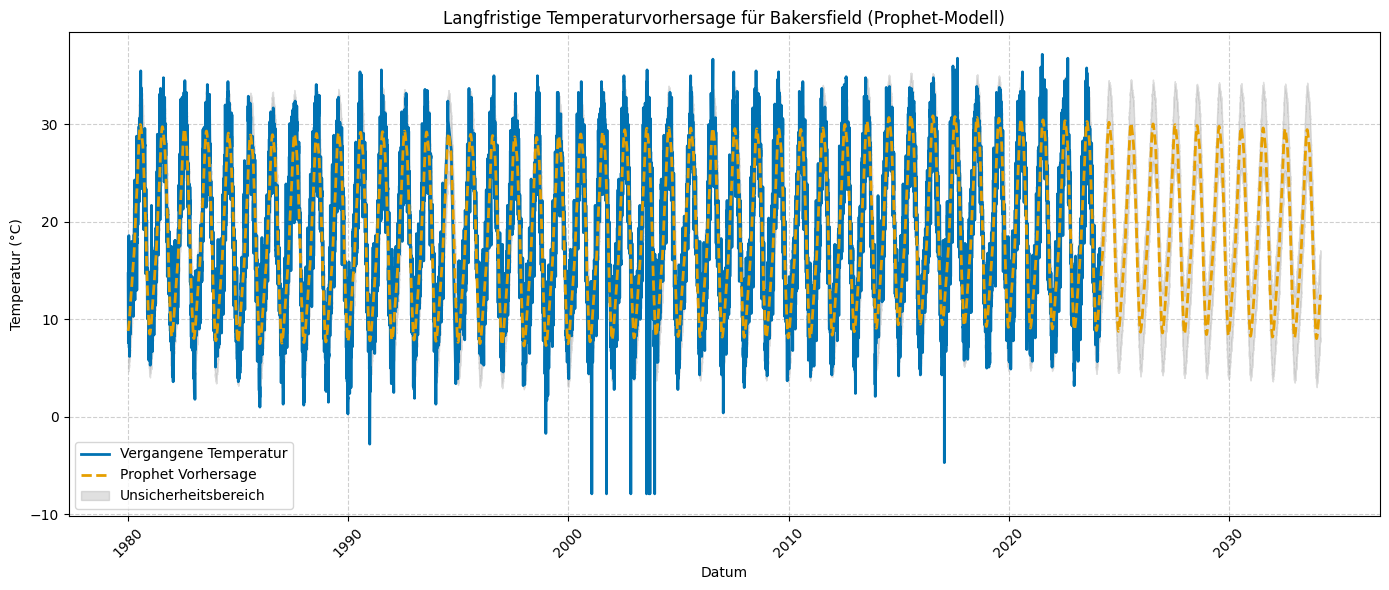

In [9]:
# Datum als Index setzen
data.index = pd.to_datetime(data.index)

# Fehlende Werte interpolieren
data['tavg'] = data['tavg'].interpolate(method='linear')

# Prophet erwartet zwei Spalten: ds (Datum), y (Wert)
df_prophet = data[['tavg']].reset_index()
df_prophet.columns = ['ds', 'y']

# Prophet-Modell aufsetzen
model = Prophet(
    yearly_seasonality=True,
    daily_seasonality=False,
    weekly_seasonality=False,
    seasonality_mode='additive'
)
model.fit(df_prophet)

# Zukunftsdaten erzeugen (10 Jahre)
future = model.make_future_dataframe(periods=10*365)
forecast = model.predict(future)

# Farbenblind-freundliche Farben (Okabe & Ito Palette)
colors = {
    'historical': '#0072B2',  # Blau
    'forecast': '#E69F00',    # Orange
    'uncertainty': '#999999'  # Grau
}

# Plotten
fig, ax = plt.subplots(figsize=(14, 6))

# Historische Temperatur
ax.plot(df_prophet['ds'], df_prophet['y'], label="Vergangene Temperatur",
        color=colors['historical'], linestyle='-', linewidth=2)

# Prognose
ax.plot(forecast['ds'], forecast['yhat'], label="Prophet Vorhersage",
        color=colors['forecast'], linestyle='--', linewidth=2)

# Unsicherheitsbereich
ax.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'],
                color=colors['uncertainty'], alpha=0.3, label="Unsicherheitsbereich")

# Achsenbeschriftungen und Titel
ax.set_xlabel("Datum")
ax.set_ylabel("Temperatur (°C)")
ax.set_title("Langfristige Temperaturvorhersage für Bakersfield (Prophet-Modell)")

# Legende, Gitter und Layout
ax.legend()
ax.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

18:01:23 - cmdstanpy - INFO - Chain [1] start processing
18:01:24 - cmdstanpy - INFO - Chain [1] done processing


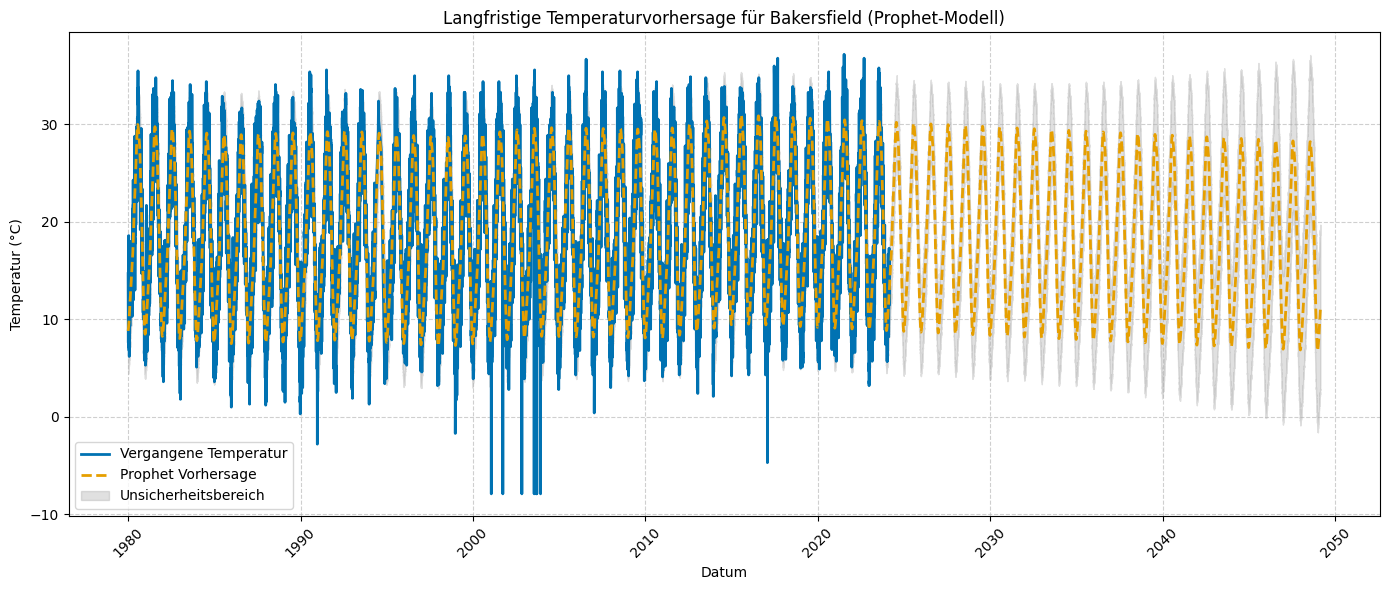

In [10]:
# Datum als Index setzen
data.index = pd.to_datetime(data.index)

# Fehlende Werte interpolieren
data['tavg'] = data['tavg'].interpolate(method='linear')

# Prophet erwartet zwei Spalten: ds (Datum), y (Wert)
df_prophet = data[['tavg']].reset_index()
df_prophet.columns = ['ds', 'y']

# Prophet-Modell aufsetzen
model = Prophet(
    yearly_seasonality=True,
    daily_seasonality=False,
    weekly_seasonality=False,
    seasonality_mode='additive'
)
model.fit(df_prophet)

# Zukunftsdaten erzeugen (10 Jahre)
future = model.make_future_dataframe(periods=25*365)
forecast = model.predict(future)

# Farbenblind-freundliche Farben (Okabe & Ito Palette)
colors = {
    'historical': '#0072B2',  # Blau
    'forecast': '#E69F00',    # Orange
    'uncertainty': '#999999'  # Grau
}

# Plotten
fig, ax = plt.subplots(figsize=(14, 6))

# Historische Temperatur
ax.plot(df_prophet['ds'], df_prophet['y'], label="Vergangene Temperatur",
        color=colors['historical'], linestyle='-', linewidth=2)

# Prognose
ax.plot(forecast['ds'], forecast['yhat'], label="Prophet Vorhersage",
        color=colors['forecast'], linestyle='--', linewidth=2)

# Unsicherheitsbereich
ax.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'],
                color=colors['uncertainty'], alpha=0.3, label="Unsicherheitsbereich")

# Achsenbeschriftungen und Titel
ax.set_xlabel("Datum")
ax.set_ylabel("Temperatur (°C)")
ax.set_title("Langfristige Temperaturvorhersage für Bakersfield (Prophet-Modell)")

# Legende, Gitter und Layout
ax.legend()
ax.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

18:01:26 - cmdstanpy - INFO - Chain [1] start processing
18:01:27 - cmdstanpy - INFO - Chain [1] done processing


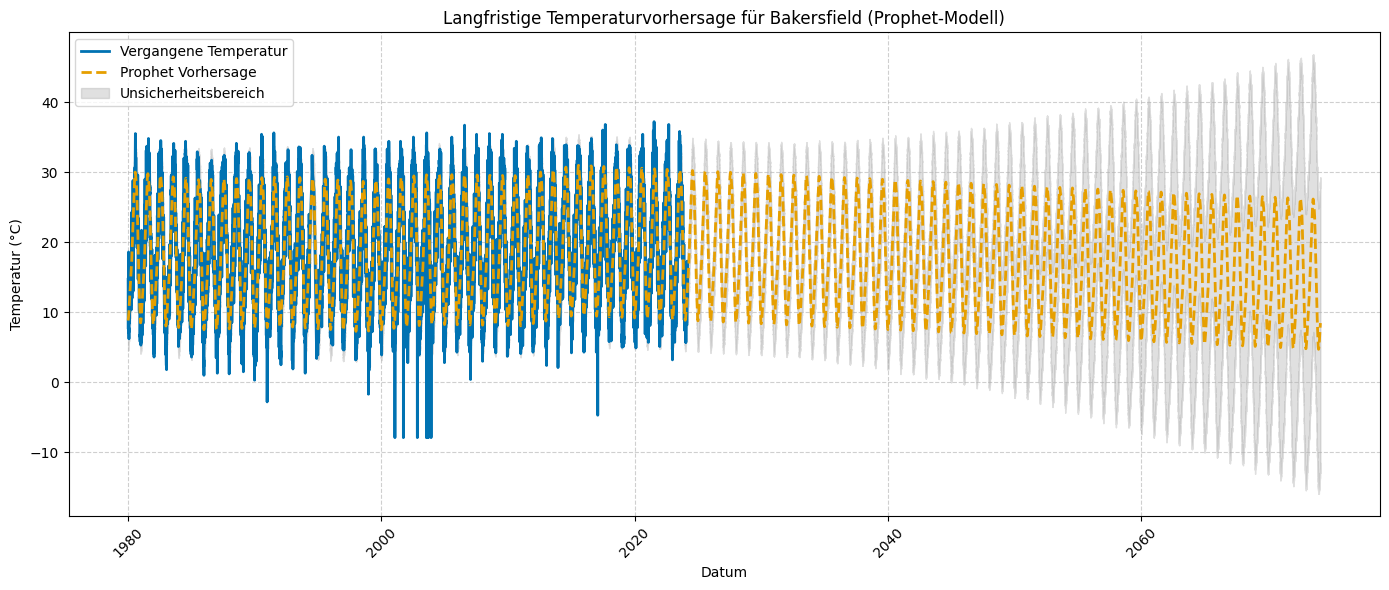

In [11]:
# Datum als Index setzen
data.index = pd.to_datetime(data.index)

# Fehlende Werte interpolieren
data['tavg'] = data['tavg'].interpolate(method='linear')

# Prophet erwartet zwei Spalten: ds (Datum), y (Wert)
df_prophet = data[['tavg']].reset_index()
df_prophet.columns = ['ds', 'y']

# Prophet-Modell aufsetzen
model = Prophet(
    yearly_seasonality=True,
    daily_seasonality=False,
    weekly_seasonality=False,
    seasonality_mode='additive'
)
model.fit(df_prophet)

# Zukunftsdaten erzeugen (10 Jahre)
future = model.make_future_dataframe(periods=50*365)
forecast = model.predict(future)

# Farbenblind-freundliche Farben (Okabe & Ito Palette)
colors = {
    'historical': '#0072B2',  # Blau
    'forecast': '#E69F00',    # Orange
    'uncertainty': '#999999'  # Grau
}

# Plotten
fig, ax = plt.subplots(figsize=(14, 6))

# Historische Temperatur
ax.plot(df_prophet['ds'], df_prophet['y'], label="Vergangene Temperatur",
        color=colors['historical'], linestyle='-', linewidth=2)

# Prognose
ax.plot(forecast['ds'], forecast['yhat'], label="Prophet Vorhersage",
        color=colors['forecast'], linestyle='--', linewidth=2)

# Unsicherheitsbereich
ax.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'],
                color=colors['uncertainty'], alpha=0.3, label="Unsicherheitsbereich")

# Achsenbeschriftungen und Titel
ax.set_xlabel("Datum")
ax.set_ylabel("Temperatur (°C)")
ax.set_title("Langfristige Temperaturvorhersage für Bakersfield (Prophet-Modell)")

# Legende, Gitter und Layout
ax.legend()
ax.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Verfügbarer Zeitraum: 1980-01-01 00:00:00 bis 2024-03-01 00:00:00
Fehlende Werte nach Verarbeitung: 0


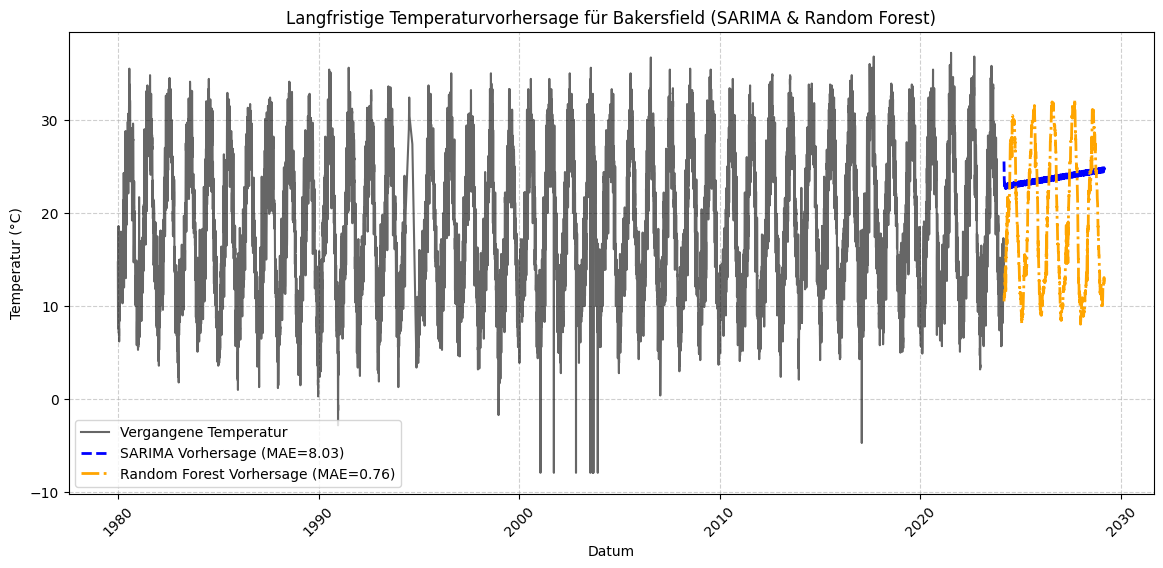

(count    16132.000000
 mean        18.759075
 std          7.904023
 min         -7.900000
 25%         12.200000
 50%         18.100000
 75%         25.700000
 max         37.200000
 Name: tavg, dtype: float64,
 8.027736600560484,
 0.7596554702433456)

In [12]:
warnings.filterwarnings("ignore")

# Sicherstellen, dass das Datum der Index ist
data.index = pd.to_datetime(data.index)

# Überprüfen, ob Meteostat-Daten verfügbar sind
print("Verfügbarer Zeitraum:", data.index.min(), "bis", data.index.max())

# Fehlende Werte in der Temperaturspalte behandeln
data['tavg'] = data['tavg'].interpolate(method='linear')  # Interpolieren
data['tavg'] = data['tavg'].fillna(method='bfill').fillna(method='ffill')  # Backfill + Forwardfill als zusätzliche Sicherung

# Prüfen, ob noch NaN-Werte vorhanden sind
print("Fehlende Werte nach Verarbeitung:", data['tavg'].isna().sum())

# Fehlende Werte in weiteren Wettervariablen auffüllen
data[['tmin', 'tmax', 'prcp', 'wspd', 'pres']] = data[['tmin', 'tmax', 'prcp', 'wspd', 'pres']].fillna(method='ffill').fillna(method='bfill')

# Temperatur-Zeitreihe extrahieren
temperature_series = data['tavg'].dropna()

# Trainings- und Testsplit
train_size = int(len(temperature_series) * 0.8)
train, test = temperature_series.iloc[:train_size], temperature_series.iloc[train_size:]

# SARIMA-Modell trainieren
sarima_model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12), enforce_stationarity=False, enforce_invertibility=False)
sarima_result = sarima_model.fit()

# Langfristige Vorhersage für 5 Jahre
forecast_steps = 5 * 365  # 5 Jahre
future_dates = pd.date_range(start=end_date, periods=forecast_steps, freq='D')
sarima_forecast = sarima_result.forecast(steps=forecast_steps)

# Random Forest Modell mit zusätzlichen Wetterfaktoren
features = data[['tmin', 'tmax', 'prcp', 'wspd', 'pres']].fillna(method='ffill').fillna(method='bfill')
target = data['tavg'].fillna(method='ffill').fillna(method='bfill')

# Überprüfung der Datenverteilung im Trainingsdatensatz
train_stats = target.describe()

# Trainings- und Testdaten für Random Forest
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, shuffle=False)

# Random Forest Modell optimieren
rf_model = RandomForestRegressor(n_estimators=500, max_depth=20, random_state=42)
rf_model.fit(X_train, y_train)

# Überprüfung: Sind future_features konstant?
future_features = features.rolling(window=30, min_periods=1).mean().iloc[-forecast_steps:].reset_index(drop=True)

# Falls zu wenige Werte vorhanden sind, mit Durchschnittswerten auffüllen
if future_features.shape[0] < forecast_steps:
    additional_rows = pd.DataFrame(np.tile(future_features.mean().values, (forecast_steps - future_features.shape[0], 1)), columns=future_features.columns)
    future_features = pd.concat([future_features, additional_rows], ignore_index=True)

# Random Forest Vorhersage
rf_forecast = rf_model.predict(future_features)

# Berechnung von Fehlerwerten
sarima_mae = mean_absolute_error(test, sarima_result.forecast(steps=len(test)))
rf_mae = mean_absolute_error(y_test, rf_model.predict(X_test))

# Ergebnisse visualisieren
plt.figure(figsize=(14, 6))
plt.plot(temperature_series.index, temperature_series, label="Vergangene Temperatur", color="black", alpha=0.6)
plt.plot(future_dates, sarima_forecast, label=f"SARIMA Vorhersage (MAE={sarima_mae:.2f})", color="blue", linestyle="--", linewidth=2)
plt.plot(future_dates, rf_forecast, label=f"Random Forest Vorhersage (MAE={rf_mae:.2f})", color="orange", linestyle="-.", linewidth=2)
plt.xlabel("Datum")
plt.ylabel("Temperatur (°C)")
plt.title("Langfristige Temperaturvorhersage für Bakersfield (SARIMA & Random Forest)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.show()

# Rückgabe der wichtigsten Werte
train_stats, sarima_mae, rf_mae

Verfügbarer Zeitraum: 1980-01-01 00:00:00 bis 2024-03-01 00:00:00
Fehlende Werte nach Verarbeitung: 0


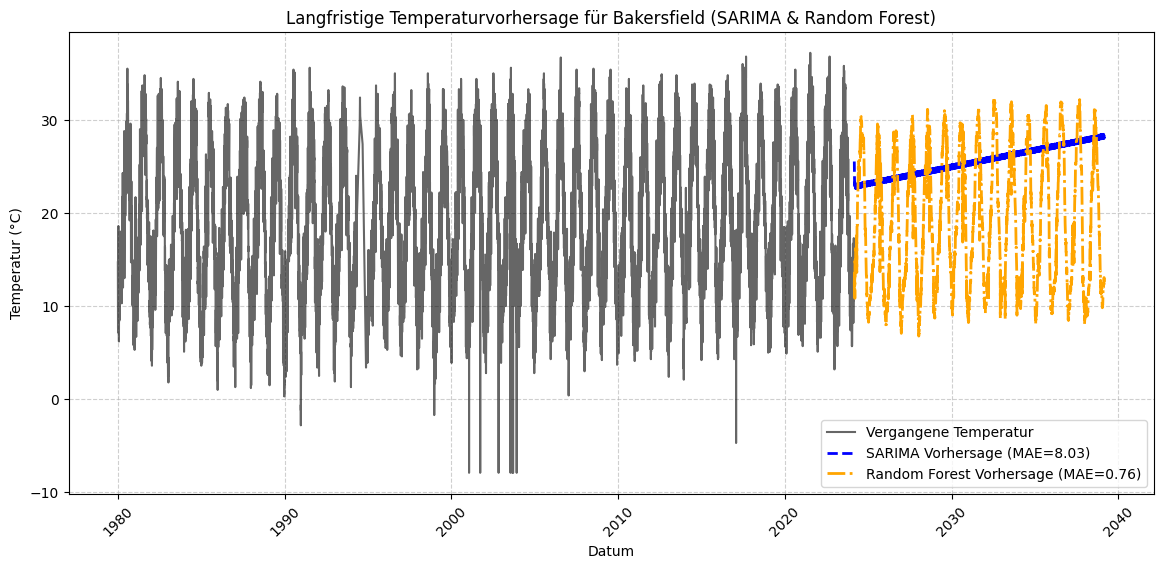

(count    16132.000000
 mean        18.759075
 std          7.904023
 min         -7.900000
 25%         12.200000
 50%         18.100000
 75%         25.700000
 max         37.200000
 Name: tavg, dtype: float64,
 8.027736600560484,
 0.7596554702433456)

In [13]:
warnings.filterwarnings("ignore")

# Sicherstellen, dass das Datum der Index ist
data.index = pd.to_datetime(data.index)

# Überprüfen, ob Meteostat-Daten verfügbar sind
print("Verfügbarer Zeitraum:", data.index.min(), "bis", data.index.max())

# Fehlende Werte in der Temperaturspalte behandeln
data['tavg'] = data['tavg'].interpolate(method='linear')  # Interpolieren
data['tavg'] = data['tavg'].fillna(method='bfill').fillna(method='ffill')  # Backfill + Forwardfill als zusätzliche Sicherung

# Prüfen, ob noch NaN-Werte vorhanden sind
print("Fehlende Werte nach Verarbeitung:", data['tavg'].isna().sum())

# Fehlende Werte in weiteren Wettervariablen auffüllen
data[['tmin', 'tmax', 'prcp', 'wspd', 'pres']] = data[['tmin', 'tmax', 'prcp', 'wspd', 'pres']].fillna(method='ffill').fillna(method='bfill')

# Temperatur-Zeitreihe extrahieren
temperature_series = data['tavg'].dropna()

# Trainings- und Testsplit
train_size = int(len(temperature_series) * 0.8)
train, test = temperature_series.iloc[:train_size], temperature_series.iloc[train_size:]

# SARIMA-Modell trainieren
sarima_model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12), enforce_stationarity=False, enforce_invertibility=False)
sarima_result = sarima_model.fit()

# Langfristige Vorhersage für 15 Jahre
forecast_steps = 15 * 365
future_dates = pd.date_range(start=end_date, periods=forecast_steps, freq='D')
sarima_forecast = sarima_result.forecast(steps=forecast_steps)

# Random Forest Modell mit zusätzlichen Wetterfaktoren
features = data[['tmin', 'tmax', 'prcp', 'wspd', 'pres']].fillna(method='ffill').fillna(method='bfill')
target = data['tavg'].fillna(method='ffill').fillna(method='bfill')

# Überprüfung der Datenverteilung im Trainingsdatensatz
train_stats = target.describe()

# Trainings- und Testdaten für Random Forest
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, shuffle=False)

# Random Forest Modell optimieren
rf_model = RandomForestRegressor(n_estimators=500, max_depth=20, random_state=42)
rf_model.fit(X_train, y_train)

# Überprüfung: Sind future_features konstant?
future_features = features.rolling(window=30, min_periods=1).mean().iloc[-forecast_steps:].reset_index(drop=True)

# Falls zu wenige Werte vorhanden sind, mit Durchschnittswerten auffüllen
if future_features.shape[0] < forecast_steps:
    additional_rows = pd.DataFrame(np.tile(future_features.mean().values, (forecast_steps - future_features.shape[0], 1)), columns=future_features.columns)
    future_features = pd.concat([future_features, additional_rows], ignore_index=True)

# Random Forest Vorhersage
rf_forecast = rf_model.predict(future_features)

# Berechnung von Fehlerwerten
sarima_mae = mean_absolute_error(test, sarima_result.forecast(steps=len(test)))
rf_mae = mean_absolute_error(y_test, rf_model.predict(X_test))

# Ergebnisse visualisieren
plt.figure(figsize=(14, 6))
plt.plot(temperature_series.index, temperature_series, label="Vergangene Temperatur", color="black", alpha=0.6)
plt.plot(future_dates, sarima_forecast, label=f"SARIMA Vorhersage (MAE={sarima_mae:.2f})", color="blue", linestyle="--", linewidth=2)
plt.plot(future_dates, rf_forecast, label=f"Random Forest Vorhersage (MAE={rf_mae:.2f})", color="orange", linestyle="-.", linewidth=2)
plt.xlabel("Datum")
plt.ylabel("Temperatur (°C)")
plt.title("Langfristige Temperaturvorhersage für Bakersfield (SARIMA & Random Forest)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.show()

# Rückgabe der wichtigsten Werte
train_stats, sarima_mae, rf_mae

ADF-Test p-Wert: 0.0000
Zeitreihe ist stationär.


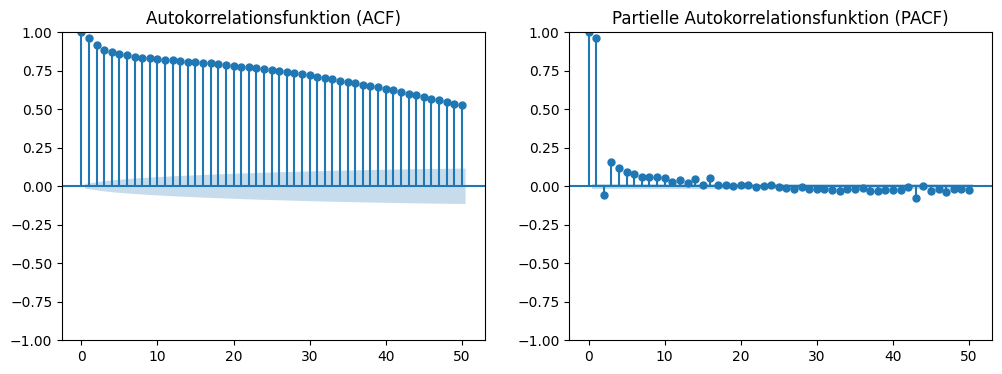

In [14]:
# Datum als Index setzen
data.index = pd.to_datetime(data.index)
data = data.sort_index()

# Fehlende Werte behandeln
data['tavg'] = data['tavg'].interpolate(method='linear')

# Stationaritätsprüfung mit ADF-Test
result = adfuller(data['tavg'])
print(f"ADF-Test p-Wert: {result[1]:.4f}")
if result[1] < 0.05:
    print("Zeitreihe ist stationär.")
    stationary_series = data['tavg']
else:
    print("Zeitreihe ist nicht stationär. Differenzierung wird angewendet.")
    stationary_series = data['tavg'].diff().dropna()


# Autokorrelationsfunktion (ACF) und partielle Autokorrelationsfunktion (PACF) plotten
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(data['tavg'].dropna(), ax=axes[0], lags=50)
axes[0].set_title("Autokorrelationsfunktion (ACF)")
plot_pacf(data['tavg'].dropna(), ax=axes[1], lags=50)
axes[1].set_title("Partielle Autokorrelationsfunktion (PACF)")
plt.show()

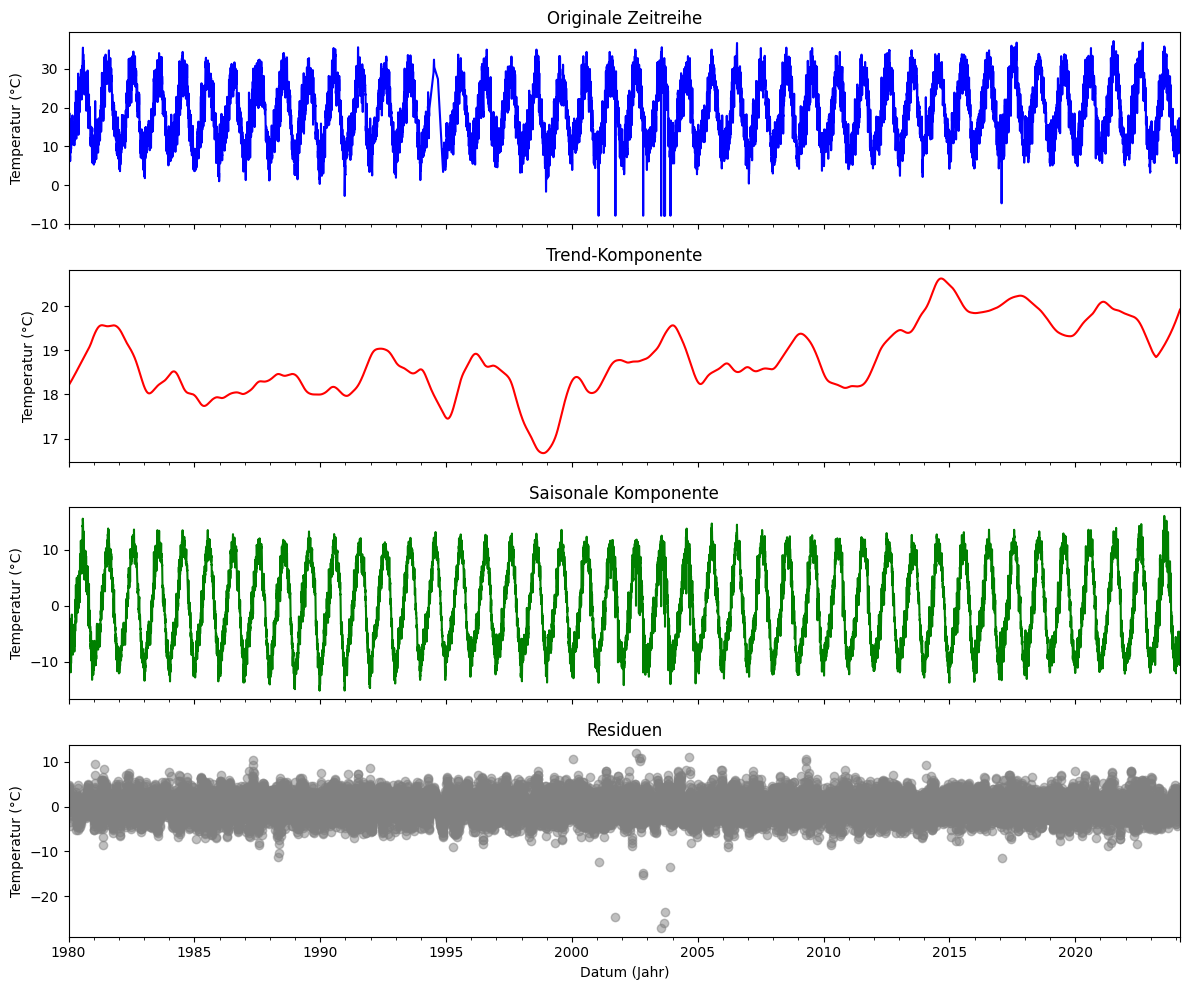

In [15]:
warnings.filterwarnings("ignore")

# Datum als Index setzen und sortieren
data.index = pd.to_datetime(data.index)
data = data.sort_index()

# Fehlende Werte behandeln
data['tavg'] = data['tavg'].interpolate(method='linear')

# NaN-Werte entfernen (sicherstellen für STL)
data = data.dropna(subset=['tavg'])

# Saisonale Dekomposition durchführen
stl = STL(data['tavg'], period=365)
decomp = stl.fit()

# Ergebnisse visualisieren
fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

data['tavg'].plot(ax=axes[0], title='Originale Zeitreihe', color='blue')
decomp.trend.plot(ax=axes[1], title='Trend-Komponente', color='red')
decomp.seasonal.plot(ax=axes[2], title='Saisonale Komponente', color='green')
axes[3].scatter(data.index, decomp.resid, color='gray', alpha=0.5)
axes[3].set_title('Residuen')

for ax in axes:
    ax.set_ylabel('Temperatur (°C)')
axes[-1].set_xlabel('Datum (Jahr)')

plt.tight_layout()
plt.show()


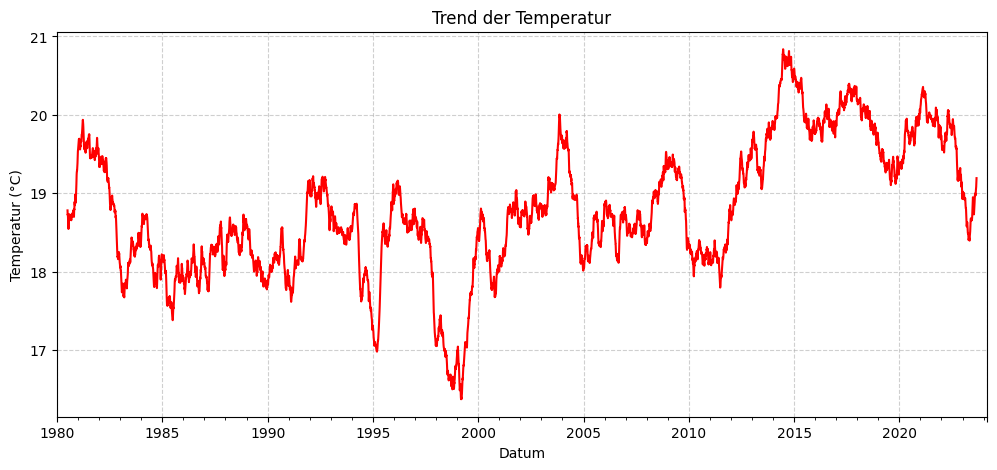

In [16]:
# Datum als Index setzen
data.index = pd.to_datetime(data.index)
data = data.sort_index()

# Fehlende Werte behandeln
data['tavg'] = data['tavg'].interpolate(method='linear')

# Saisonale Dekomposition durchführen
decomposed = seasonal_decompose(data['tavg'], model='additive', period=365)

# Nur den Trend plotten
plt.figure(figsize=(12, 5))
decomposed.trend.plot(title='Trend der Temperatur', color='red')
plt.xlabel('Datum')
plt.ylabel('Temperatur (°C)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()